# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [1]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [2]:
bandit0 = BanditProblem(0)

In [3]:
bandit0.get_num_arms()

3

In [4]:
bandit0.get_reward(arm=0)

1.8255111545554434

Investigating reward distributions...
Arm 0: Mean = 0.897, Std = 0.813, Range = [0.0, 4.1]
Arm 1: Mean = 0.548, Std = 0.606, Range = [0.0, 2.8]
Arm 2: Mean = 0.848, Std = 0.736, Range = [0.0, 4.4]

Performance comparison:
Arm means: ['0.897', '0.548', '0.848']
Best arm: 0
Performance gaps: ['0.000', '0.349', '0.049']


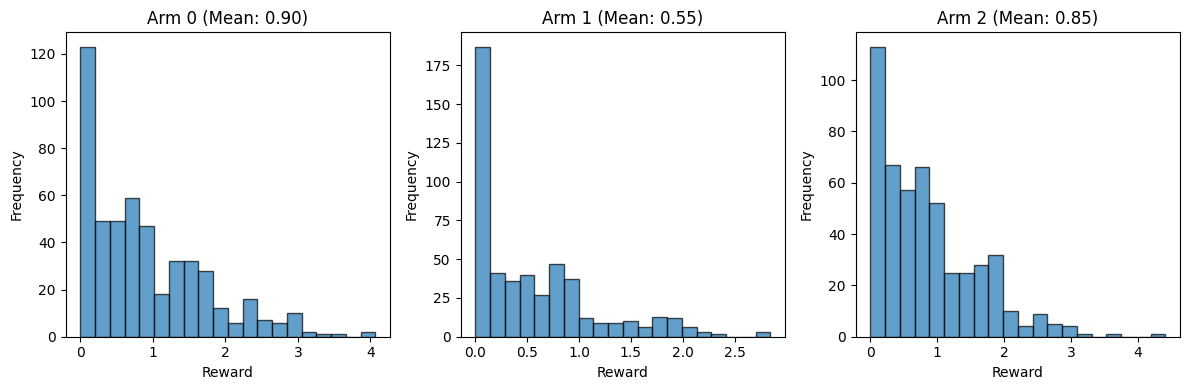


Recommended Algorithm: Thompson Sampling


In [5]:
# YOUR CHANGES HERE

# Quick investigation of all arms
import numpy as np
import matplotlib.pyplot as plt

# Sample each arm multiple times to understand distributions
num_samples = 500
results = {}

print("Investigating reward distributions...")
for arm in range(bandit0.get_num_arms()):
    rewards = []
    for i in range(num_samples):
        reward = bandit0.get_reward(arm)
        rewards.append(reward)
    
    results[arm] = rewards
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    
    print(f"Arm {arm}: Mean = {mean_reward:.3f}, Std = {std_reward:.3f}, Range = [{min(rewards):.1f}, {max(rewards):.1f}]")

# Compare arms
means = [np.mean(results[arm]) for arm in range(3)]
best_arm = np.argmax(means)
gaps = [max(means) - mean for mean in means]

print(f"\nPerformance comparison:")
print(f"Arm means: {[f'{m:.3f}' for m in means]}")
print(f"Best arm: {best_arm}")
print(f"Performance gaps: {[f'{g:.3f}' for g in gaps]}")

# Create histogram
plt.figure(figsize=(12, 4))
for arm in range(3):
    plt.subplot(1, 3, arm + 1)
    plt.hist(results[arm], bins=20, alpha=0.7, edgecolor='black')
    plt.title(f'Arm {arm} (Mean: {means[arm]:.2f})')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Algorithm recommendation
largest_gap = max([g for g in gaps if g > 0])
smallest_nonzero_gap = min([g for g in gaps if g > 0])

# Check if there are both large and small gaps (mixed scenario)
if largest_gap > 0.3 and smallest_nonzero_gap < 0.1:
    algorithm = "Thompson Sampling"
elif largest_gap > 0.4:
    algorithm = "Upper Confidence Bound (UCB)"
else:
    algorithm = "Epsilon-Greedy (ε = 0.1)"

print(f"\nRecommended Algorithm: {algorithm}")

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [6]:
# YOUR CHANGES HERE

import numpy as np
import csv

class ThompsonSampling:
    def __init__(self, num_arms, seed=None):
        self.num_arms = num_arms
        self.rng = np.random.default_rng(seed)
        
        # Beta priors for each arm: Beta(α, β)
        # Start with uniform prior Beta(1, 1)
        self.alpha = np.ones(num_arms)  # Success count + 1
        self.beta = np.ones(num_arms)   # Failure count + 1
        self.counts = np.zeros(num_arms)
        self.total_rewards = np.zeros(num_arms)
    
    def select_arm(self):
        # Sample from Beta posterior for each arm
        samples = []
        for arm in range(self.num_arms):
            # Sample success probability from Beta(α, β)
            theta = self.rng.beta(self.alpha[arm], self.beta[arm])
            samples.append(theta)
        
        # Choose arm with highest sample
        return np.argmax(samples)
    
    def update(self, arm, reward):
        # Update counts
        self.counts[arm] += 1
        self.total_rewards[arm] += reward
        
        
        max_reward = 4.4 
        
        if reward > 1.5:
            self.alpha[arm] += 1  # Treat as success
        else:
            self.beta[arm] += 1   # Treat as failure

# Initialize Thompson Sampling with seed 2025002
bandit = BanditProblem(2025002)  
ts = ThompsonSampling(num_arms=bandit.get_num_arms(), seed=2025002)

# Run for 1000 actions
history = []
print("Running Thompson Sampling for 1000 actions...")

for step in range(1000):
    # Select arm using Thompson Sampling
    chosen_arm = ts.select_arm()
    
    # Get reward from bandit
    reward = bandit.get_reward(chosen_arm)
    
    # Update Thompson Sampling
    ts.update(chosen_arm, reward)
    
    # Record history
    history.append([chosen_arm, reward])
    
    if (step + 1) % 100 == 0:
        print(f"Step {step + 1}: Arm {chosen_arm}, Reward {reward:.3f}")




Running Thompson Sampling for 1000 actions...
Step 100: Arm 2, Reward 0.512
Step 200: Arm 1, Reward 1.924
Step 300: Arm 0, Reward 0.000
Step 400: Arm 0, Reward 0.616
Step 500: Arm 0, Reward 0.817
Step 600: Arm 1, Reward 0.000
Step 700: Arm 1, Reward 0.097
Step 800: Arm 0, Reward 0.053
Step 900: Arm 0, Reward 0.785
Step 1000: Arm 0, Reward 0.379


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [7]:
# YOUR CHANGES HERE

# Write history.tsv
with open('history.tsv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter='\t')
    writer.writerow(['action', 'reward'])
    writer.writerows(history)



Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [8]:
# YOUR CHANGES HERE

import csv
import numpy as np

# Read the history.tsv file from Part 2
history_data = []
with open('history.tsv', 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    header = next(reader)  # Skip header row
    for row in reader:
        action = int(row[0])
        reward = float(row[1])
        history_data.append((action, reward))

print(f"Loaded {len(history_data)} action-reward pairs from history.tsv")

# Group rewards by action (arm)
arm_rewards = {0: [], 1: [], 2: []}

for action, reward in history_data:
    arm_rewards[action].append(reward)

print("\nData summary:")
for arm in range(3):
    count = len(arm_rewards[arm])
    print(f"Arm {arm}: {count} pulls")

# Calculate statistics for each arm
action_stats = []

for arm in range(3):
    if len(arm_rewards[arm]) > 0:
        rewards = arm_rewards[arm]
        min_reward = min(rewards)
        mean_reward = np.mean(rewards)
        max_reward = max(rewards)
    else:
        # Handle case where arm was never pulled
        min_reward = 0.0
        mean_reward = 0.0
        max_reward = 0.0
    
    action_stats.append([arm, min_reward, mean_reward, max_reward])
    print(f"Arm {arm}: Min={min_reward:.3f}, Mean={mean_reward:.3f}, Max={max_reward:.3f}")





Loaded 1000 action-reward pairs from history.tsv

Data summary:
Arm 0: 607 pulls
Arm 1: 352 pulls
Arm 2: 41 pulls
Arm 0: Min=0.000, Mean=0.568, Max=2.989
Arm 1: Min=0.000, Mean=0.540, Max=3.761
Arm 2: Min=0.000, Mean=0.250, Max=0.982


In [9]:
# Write actions.tsv file
with open('actions.tsv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter='\t')
    # Write header
    writer.writerow(['action', 'min_reward', 'mean_reward', 'max_reward'])
    # Write data
    writer.writerows(action_stats)

print(f"\nFile 'actions.tsv' created with statistics for each arm")


File 'actions.tsv' created with statistics for each arm


Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [12]:
# YOUR CHANGES HERE

import csv
import numpy as np


print("Estimating true expected rewards for each arm...")

bandit = BanditProblem(2025002)  
num_samples = 1000  

true_expected_rewards = []
for arm in range(bandit.get_num_arms()):
    rewards = [bandit.get_reward(arm) for _ in range(num_samples)]
    expected_reward = np.mean(rewards)
    true_expected_rewards.append(expected_reward)
    print(f"Arm {arm}: True expected reward ≈ {expected_reward:.4f}")

# The optimal expected reward is the maximum
optimal_reward = max(true_expected_rewards)
best_arm = np.argmax(true_expected_rewards)
print(f"\nBest arm: {best_arm} with expected reward {optimal_reward:.4f}")

# Calculate regret for each strategy
strategies_regret = []

# 1. Uniform strategy: Pick each arm with probability 1/3
uniform_expected_reward = np.mean(true_expected_rewards)
uniform_regret = (optimal_reward - uniform_expected_reward) * 1000  
strategies_regret.append(["uniform", uniform_regret])
print(f"\nUniform strategy:")
print(f"  Expected reward per action: {uniform_expected_reward:.4f}")
print(f"  Total regret over 1000 actions: {uniform_regret:.4f}")

# 2. Just-i strategies: Always pick arm i
for arm in range(bandit.get_num_arms()):
    just_i_expected_reward = true_expected_rewards[arm]
    just_i_regret = (optimal_reward - just_i_expected_reward) * 1000
    strategies_regret.append([f"just-{arm}", just_i_regret])
    print(f"\nJust-{arm} strategy:")
    print(f"  Expected reward per action: {just_i_expected_reward:.4f}")
    print(f"  Total regret over 1000 actions: {just_i_regret:.4f}")

# 3. Actual strategy: Use results from Part 2 (Thompson Sampling)
# Read the actual rewards from history.tsv
actual_rewards = []
with open('history.tsv', 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    header = next(reader)  
    for row in reader:
        reward = float(row[1])
        actual_rewards.append(reward)

actual_total_reward = sum(actual_rewards)
optimal_total_reward = optimal_reward * 1000
actual_regret = optimal_total_reward - actual_total_reward

strategies_regret.append(["actual", actual_regret])
print(f"\nActual strategy (Thompson Sampling):")
print(f"  Total reward achieved: {actual_total_reward:.4f}")
print(f"  Optimal total reward: {optimal_total_reward:.4f}")
print(f"  Total regret: {actual_regret:.4f}")



Estimating true expected rewards for each arm...
Arm 0: True expected reward ≈ 0.5668
Arm 1: True expected reward ≈ 0.5373
Arm 2: True expected reward ≈ 0.1931

Best arm: 0 with expected reward 0.5668

Uniform strategy:
  Expected reward per action: 0.4324
  Total regret over 1000 actions: 134.4105

Just-0 strategy:
  Expected reward per action: 0.5668
  Total regret over 1000 actions: 0.0000

Just-1 strategy:
  Expected reward per action: 0.5373
  Total regret over 1000 actions: 29.5280

Just-2 strategy:
  Expected reward per action: 0.1931
  Total regret over 1000 actions: 373.7035

Actual strategy (Thompson Sampling):
  Total reward achieved: 544.8895
  Optimal total reward: 566.7941
  Total regret: 21.9046


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [13]:
# YOUR CHANGES HERE

# Write strategies.tsv
with open('strategies.tsv', 'w', newline='') as file:
    writer = csv.writer(file, delimiter='\t')
    writer.writerow(['strategy', 'regret'])  # Header
    writer.writerows(strategies_regret)

print(f"\nstrategies.tsv written successfully")


strategies.tsv written successfully


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.